# A simple 2D Multimodal Flow Matching model

This notebook trains and evaluates a multimodal FM model that jointly handles
a discrete modality (categorical data) and a continuous modality (real‑valued 2‑D data).

Dataset: 2D discrete/continuous checkerboard
Model (probability denoiser/velocity): MLPs for each modality and a shared Transformer trunk

## Imports and init device

In [1]:
import time
import torch
from torch import nn, Tensor

# flow_matching
from flow_matching.utils.multimodal import Flow
from flow_matching.path.scheduler import (
    PolynomialConvexScheduler,  # discrete scheduler (training)
    CondOTScheduler,  # continuous scheduler (training)
)
from flow_matching.path import MixtureDiscreteProbPath, AffineProbPath

# visualization
import matplotlib.pyplot as plt

# To avoide meshgrid warning
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module='torch')

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"
    print("Using GPU")
elif torch.backends.mps.is_available():
    device = "mps"
    print("Using MPS")
else:
    device = "cpu"
    print("Using CPU")

Using MPS


In [3]:
torch.manual_seed(42)

## Shared model

In [4]:
class SharedTransformer(nn.Module):
    """
    Shared Transformer trunk used by both modalities.
    """
    def __init__(self, hidden_dim: int = 128, nhead: int = 4, num_layers: int = 2):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

    def forward(self, x: Tensor) -> Tensor:
        """
        x: (seq_len, batch, hidden_dim)
        Returns transformed tensor of same shape.
        """
        return self.transformer(x)

## Discrete modality dataset and model

In [5]:
def inf_train_gen_discrete(
    n_grid_points: int = 128,
    batch_size: int = 200,
    device: str = "cpu",
) -> Tensor:
    """
    Generate a batch of discrete (categorical) samples.
    Returns a tensor of shape (batch, 2) with integer token IDs.
    """
    assert n_grid_points % 4 == 0, "grid size must be divisible by 4"
    n_grid_points //= 4

    x1 = torch.randint(low=0, high=n_grid_points * 4, size=(batch_size,), device=device)
    samples_x2 = torch.randint(
        low=0, high=n_grid_points, size=(batch_size,), device=device
    )

    x2 = (
        samples_x2
        + 2 * n_grid_points
        - torch.randint(low=0, high=2, size=(batch_size,), device=device)
        * 2
        * n_grid_points
        + (torch.floor(x1 / n_grid_points) % 2) * n_grid_points
    )
    return torch.stack([x1, x2], dim=1).long()


class Swish(nn.Module):
    """Swish activation (x * sigmoid(x))."""

    def forward(self, x: Tensor) -> Tensor:
        return torch.sigmoid(x) * x


class DiscreteTransformerModel(nn.Module):
    """
    Model for the discrete modality with separate input and output heads,
    sharing a common Transformer trunk.
    """
    def __init__(
        self,
        shared_transformer: SharedTransformer,
        vocab_size: int = 128,
        time_dim: int = 1,
        hidden_dim: int = 128,
        length: int = 2,
    ):
        super().__init__()
        self.shared = shared_transformer
        self.input_dim = vocab_size
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim
        self.length = length

        self.time_embedding = nn.Linear(1, time_dim)
        self.token_embedding = nn.Embedding(vocab_size, hidden_dim)
        self.input_proj = nn.Linear(hidden_dim + time_dim, hidden_dim)
        self.output_head = nn.Linear(hidden_dim, vocab_size)
        self.activation = Swish()

    def sample_shape(self, batch_size: int) -> torch.Size:
        return torch.Size((batch_size, self.length))

    def sample_prior(self, shape: torch.Size, device: torch.device) -> Tensor:
        return torch.randint(low=0, high=self.input_dim, size=shape, device=device)

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        """
        x: (B, length) integer token IDs
        t: (B,) time scalar
        Returns logits of shape (B, length, vocab_size or input_dim)
        """
        if t.ndim == 0:
            t = t.unsqueeze(0).expand(x.shape[0])

        # Token embedding
        x_emb = self.token_embedding(x)  # (B, length, hidden_dim)

        # Time embedding
        t_emb = self.time_embedding(t.unsqueeze(-1).float())  # (B, time_dim)
        t_emb = t_emb.unsqueeze(1).expand(-1, self.length, -1)  # (B, length, time_dim)

        # Concatenate and project
        h = torch.cat([x_emb, t_emb], dim=-1)  # (B, length, hidden_dim+time_dim)
        h = self.input_proj(h)  # (B, length, hidden_dim)

        # Transformer expects (seq_len, batch, hidden_dim)
        h = h.permute(1, 0, 2)  # (length, B, hidden_dim)
        h = self.shared(h)  # (length, B, hidden_dim)
        h = h.permute(1, 0, 2)  # (B, length, hidden_dim)

        # Output logits
        h = self.activation(h)
        logits = self.output_head(h)  # (B, length, vocab_size or input_dim)
        return logits

# Continuous modality dataset and model

In [6]:
def inf_train_gen_continuous(batch_size: int = 200, device: str = "cpu") -> Tensor:
    """
    Generate a batch of 2-D continuous points from a checkerboard-like distribution.
    Returns a tensor of shape (batch, 2).
    """
    x1 = torch.rand(batch_size, device=device) * 4 - 2
    x2_ = (
        torch.rand(batch_size, device=device)
        - torch.randint(high=2, size=(batch_size,), device=device) * 2
    )
    x2 = x2_ + (torch.floor(x1) % 2)
    data = torch.stack([x1, x2], dim=1) / 0.45
    return data.float()


class ContinuousTransformerModel(nn.Module):
    """
    Model for the continuous modality with separate input and output heads,
    sharing a common Transformer trunk.
    """
    def __init__(
        self,
        shared_transformer: SharedTransformer,
        input_dim: int = 2,
        time_dim: int = 1,
        hidden_dim: int = 128,
    ):
        super().__init__()
        self.shared = shared_transformer
        self.input_dim = input_dim
        self.time_dim = time_dim
        self.hidden_dim = hidden_dim

        self.time_embedding = nn.Linear(1, time_dim)
        self.position_proj = nn.Linear(input_dim, hidden_dim)
        self.input_proj = nn.Linear(hidden_dim + time_dim, hidden_dim)
        self.output_head = nn.Linear(hidden_dim, input_dim)
        self.activation = Swish()

    def sample_shape(self, batch_size: int) -> torch.Size:
        return torch.Size((batch_size, self.input_dim))

    def sample_prior(self, shape: torch.Size, device: torch.device) -> Tensor:
        return torch.randn(shape, device=device)

    def forward(self, x: Tensor, t: Tensor) -> Tensor:
        """
        x: (B, input_dim) positions
        t: (B,) time scalar
        Returns velocity vectors of shape (B, input_dim)
        """
        if t.ndim == 0:
            t = t.unsqueeze(0).expand(x.shape[0])

        # Position projection
        x_emb = self.position_proj(x)  # (B, hidden_dim)

        # Time embedding
        t_emb = self.time_embedding(t.unsqueeze(-1).float())  # (B, time_dim)

        # Concatenate and project
        h = torch.cat([x_emb, t_emb], dim=-1)  # (B, hidden_dim+time_dim)
        h = self.input_proj(h)  # (B, hidden_dim)

        # Transformer expects (seq_len, batch, hidden_dim) with seq_len=1
        h = h.unsqueeze(0)  # (1, B, hidden_dim)
        h = self.shared(h)  # (1, B, hidden_dim)
        h = h.squeeze(0)  # (B, hidden_dim)

        # Output velocity
        h = self.activation(h)
        velocity = self.output_head(h)  # (B, input_dim)
        return velocity

## Build multimodal model

In [7]:
# ---- Discrete side -------------------------------------------------
vocab_size = 128
added_token = 0  # uniform source distribution → no extra token
vocab_size += added_token
length = 2  # 2 tokens per sample

# Shared transformer trunk
shared_transformer = SharedTransformer(hidden_dim=128, nhead=4, num_layers=2).to(device)

discrete_model = DiscreteTransformerModel(
    shared_transformer=shared_transformer,
    vocab_size=vocab_size,
    time_dim=1,
    hidden_dim=128,
    length=length,
).to(device)
discrete_path = MixtureDiscreteProbPath(scheduler=PolynomialConvexScheduler(n=2.0))

# ---- Continuous side -----------------------------------------------
continuous_model = ContinuousTransformerModel(
    shared_transformer=shared_transformer,
    input_dim=length,
    time_dim=1,
    hidden_dim=128,
).to(device)
continuous_path = AffineProbPath(scheduler=CondOTScheduler())

# ---- Assemble modalities dict ---------------------------------------
modalities = {
    "discrete": {
        "model": discrete_model,
        "path": discrete_path,
        # loss omitted → Flow will use MixturePathGeneralizedKL automatically
    },
    "continuous": {
        "model": continuous_model,
        "path": continuous_path,
        # loss omitted → Flow will use MSE loss automatically
    },
}

## Instantiate the multimodal Flow model

In [8]:
flow = Flow(modalities=modalities)

# Optimizer (optimises both modality models)
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)

## Training loop

In [9]:
lr = 1e-3
batch_size = 1024 # adjust as needed to fit in memory
iterations = 12001
print_every = 3000
epsilon = 1e-3

source_distribution = "uniform"  # for the discrete modality

start_time = time.time()
for i in range(iterations):
    optimizer.zero_grad()

    # ---- Discrete data -------------------------------------------------
    x1_disc = inf_train_gen_discrete(
        n_grid_points=vocab_size - added_token,
        batch_size=batch_size,
        device=device,
    )
    if source_distribution == "uniform":
        x0_disc = torch.randint_like(x1_disc, high=vocab_size)
    else:  # mask case (not used here)
        raise NotImplementedError

    # ---- Continuous data -----------------------------------------------
    x1_cont = inf_train_gen_continuous(batch_size=batch_size, device=device)
    x0_cont = torch.randn_like(x1_cont)  # isotropic Gaussian prior

    # ---- Sample a common time tensor for both modalities ---------------
    t = torch.rand(batch_size, device=device) * (1 - epsilon)

    # ---- Sample from each path to obtain x_t ---------------------------
    disc_path_sample = discrete_path.sample(t=t, x_0=x0_disc, x_1=x1_disc)
    cont_path_sample = continuous_path.sample(t=t, x_0=x0_cont, x_1=x1_cont)

    # ---- Build the inputs dict expected by Flow.training_loss -----------
    inputs = {
        "discrete": (x1_disc, disc_path_sample.x_t, None),  # dx_t is None for discrete
        "continuous": (x1_cont, cont_path_sample.x_t, cont_path_sample.dx_t),
    }

    # ---- Compute total loss and back‑propagate -------------------------
    loss = flow.training_loss(inputs=inputs, t=t)
    loss.backward()
    optimizer.step()

    # ---- Logging -------------------------------------------------------
    if (i + 1) % print_every == 0:
        elapsed = time.time() - start_time
        print(
            f"| iter {i+1:6d} | {elapsed*1000/print_every:5.2f} ms/step | loss {loss.item():8.3f} "
        )
        start_time = time.time()

| iter   3000 |  9.83 ms/step | loss    9.204 
| iter   6000 | 10.00 ms/step | loss    9.772 
| iter   9000 | 10.02 ms/step | loss    9.799 
| iter  12000 | 10.02 ms/step | loss    8.503 


## Sampling from the trained multimodal model

In [10]:
flow.eval()  # switch to eval mode for sampling
samples = flow.sample(batch_size=2_000, device=device, steps=1000)

## Visualization

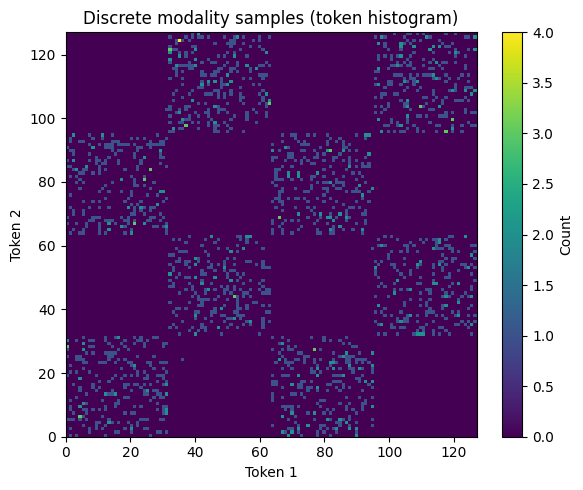

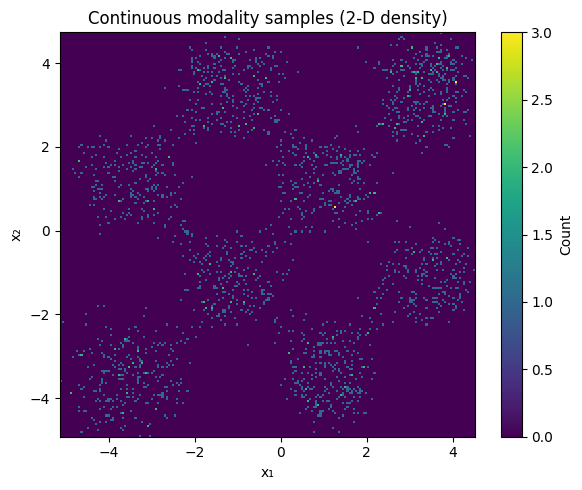

In [11]:
# ---- Discrete modality -------------------------------------------------
discrete_samples = samples["discrete"].cpu().numpy()  # shape (N, 2) integer tokens
vocab = vocab_size

# Plot a 2‑D histogram of the discrete samples
plt.figure(figsize=(6, 5))
plt.hist2d(
    discrete_samples[:, 0],
    discrete_samples[:, 1],
    bins=vocab,
    cmap="viridis",
)
plt.title("Discrete modality samples (token histogram)")
plt.xlabel("Token 1")
plt.ylabel("Token 2")
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()

# ---- Continuous modality -----------------------------------------------
continuous_samples = samples["continuous"].cpu().numpy()  # shape (N, 2)

# Plot a 2‑D histogram of the continuous samples
plt.figure(figsize=(6, 5))
plt.hist2d(
    continuous_samples[:, 0],
    continuous_samples[:, 1],
    bins=200,
    cmap="viridis",
)
plt.title("Continuous modality samples (2-D density)")
plt.xlabel("x₁")
plt.ylabel("x₂")
plt.colorbar(label="Count")
plt.tight_layout()
plt.show()